In [1]:
import os
import utils
import processing
import pandas as pd
import numpy as np
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from functools import partial
from tqdm import tqdm

In [2]:
# Environment variables
PROJECTPATH = os.getenv('PROJECTPATH')

In [3]:
def correlate_images(imgs, mask):
    
    img1 = processing.import_image(img = imgs[0], mask = mask)
    img2 = processing.import_image(img = imgs[1], mask = mask)
    cor = np.corrcoef(x = img1, y = img2)[0,1]
    
    return cor

In [4]:
params_id = 779

# Output directory
output_dir = os.path.join('outputs', 'human_cluster_correlations', 'v3', str(params_id))
if not os.path.exists(output_dir): 
    os.makedirs(output_dir)

registration_dir = 'data/human/registration/v3/'
pipeline_dir = 'data/cross_species/v3/'

pipeline_dir = os.path.join(PROJECTPATH, pipeline_dir)

metadata = os.path.join(pipeline_dir, 'metadata.csv')
metadata = utils.fetch_params_metadata(metadata, id = params_id)
human_params_ids = (metadata['input_1_id'][0], metadata['input_2_id'][0])

similarity_dir = os.path.join(pipeline_dir, str(params_id), 'similarity')

human_pipeline_dir = 'data/human/derivatives/v3/'
human_pipeline_dir = os.path.join(PROJECTPATH, human_pipeline_dir)
human_pipeline_dirs = [os.path.join(human_pipeline_dir, pid) for pid in human_params_ids]

centroid_dirs = [os.path.join(path, 'centroids', 'resolution_0.8') for path in human_pipeline_dirs]

registration_dir = os.path.join(PROJECTPATH, registration_dir)

mask = os.path.join(registration_dir, 'reference_files', 'mask_0.8mm.mnc')

jacobians = ('absolute', 'relative')

# Import transcriptomic similarity

In [6]:
# Import similarity values
similarity_file = os.path.join(similarity_dir, 'similarity.csv')
df_sim = pd.read_csv(similarity_file)

# Dictionary to store data frames
expr_sim = dict(absolute = None, relative = None)
for j in jacobians:

    # Filter images for Jacobian
    ind_img1_jac = df_sim['img1'].str.contains(j)
    ind_img2_jac = df_sim['img2'].str.contains(j)
    ind_jac = ind_img1_jac & ind_img2_jac
    df_sim_jac = df_sim.loc[ind_jac].copy()
    
    # Remove paths
    df_sim_jac['img1'] = df_sim_jac['img1'].apply(os.path.basename)
    df_sim_jac['img2'] = df_sim_jac['img2'].apply(os.path.basename)
    
    # Sort by file name
    df_sim_jac = df_sim_jac.sort_values(['img1', 'img2'])
    
    # Assign data frame to dict
    expr_sim[j] = df_sim_jac.reset_index(drop = True)

# Compute image similarity

In [15]:
run = False

# Correlation mapping function
map_cor = partial(correlate_images, mask = mask)

# Jacobians
img_sim = dict(absolute = None, relative = None)
for j in jacobians:
    
    outfile = 'centroid_correlations_{}.csv'.format(j)
    outfile = os.path.join(output_dir, outfile)
    
    if run:

        # Paths to POND and HBN centroid images
        centroid_dirs_j = [os.path.join(path, j) for path in centroid_dirs]
        centroid_imgs_j = [[os.path.join(path, file) for file in os.listdir(path)] for path in centroid_dirs_j]

        # Generate all centroid pairs
        centroid_pairs = list(product(centroid_imgs_j[0], centroid_imgs_j[1]))

    #     centroid_pairs = centroid_pairs[:50]

        pool = mp.Pool(12)
        correlations = []
        for cor in tqdm(pool.imap(map_cor, centroid_pairs), total = len(centroid_pairs)):
            correlations.append(cor)
        pool.close()
        pool.join()

        df_img_sim = pd.DataFrame(centroid_pairs, columns = ['img1', 'img2'])
        df_img_sim['similarity'] = correlations

        df_img_sim['img1'] = df_img_sim['img1'].apply(os.path.basename)
        df_img_sim['img2'] = df_img_sim['img2'].apply(os.path.basename)
        df_img_sim = df_img_sim.sort_values(['img1', 'img2'])

        # Assign data frame to dict
        img_sim[j] = df_img_sim.reset_index(drop = True)

        df_img_sim.to_csv(outfile, index = False)
    
    else:
        
        img_sim[j] = pd.read_csv(outfile)

# Correlating correlations

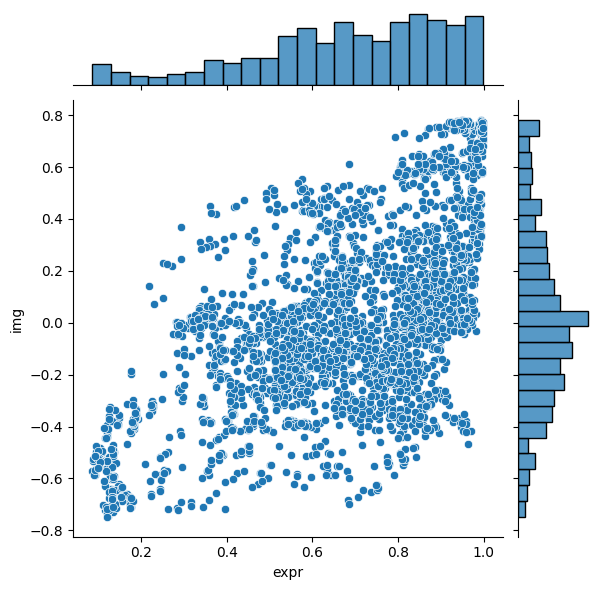

In [30]:
# j = 'absolute'
j = 'relative'


df_corr = pd.DataFrame(dict(expr = expr_sim[j]['similarity'].to_numpy(),
                            img = img_sim[j]['similarity'].to_numpy()))

sns.jointplot(x = 'expr', y = 'img', data = df_corr)

In [27]:
import seaborn as sns